# 0. Architecture of a classification neural network

Before we get into writing code, let's look at the general architecture of a classification neural network.

| **Hyperparameter** | **Binary Classification** | **Multiclass Classification** |
|---------------------|---------------------------|--------------------------------|
| **Input layer shape** (`in_features`) | Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction) | Same as binary classification |
| **Hidden layer(s)** | Problem specific, minimum = 1, maximum = unlimited | Same as binary classification |
| **Neurons per hidden layer** | Problem specific, generally 10 to 512 | Same as binary classification |
| **Output layer shape** (`out_features`) | 1 (one class or the other) | 1 per class (e.g. 3 for food, person or dog photo) |
| **Hidden layer activation** | Usually [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) (rectified linear unit) but [can be many others](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) | Same as binary classification |
| **Output activation** | Sigmoid (`torch.sigmoid` in PyTorch) | Softmax (`torch.softmax` in PyTorch) |
| **Loss function** | Binary crossentropy (`torch.nn.BCELoss` in PyTorch) | Cross entropy (`torch.nn.CrossEntropyLoss` in PyTorch) |
| **Optimizer** | [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) (stochastic gradient descent), [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) (see `torch.optim` for more options) | Same as binary classification |


# 1. Make classification data and get it ready

In [67]:
from sklearn.datasets import make_circles
import torch
n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state= 42)

In [68]:
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

We can see that there are 2 features of X

In [69]:
import pandas as pd

circles = pd.DataFrame({'X1' : X[:, 0], 'X2' : X[:, 1], 'label' : y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [70]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

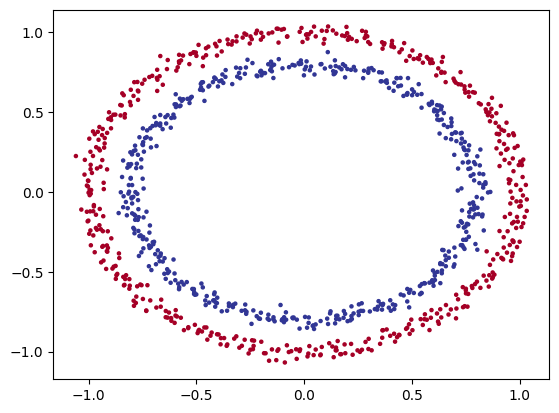

In [71]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0], y=X[:,1], c=y, s=5, cmap=plt.cm.RdYlBu)
plt.show()

## Input and output shape

In [72]:
X_sample = X[0]
y_sample = y[0]

print(X_sample, y_sample)
print(X_sample.shape, y_sample.shape)

[0.75424625 0.23148074] 1
(2,) ()


## turn data into tensors and create train and test splits

In [73]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [74]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

### Helper function to split train and test set

In [75]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

# Building a model

In [76]:
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [77]:
class CircleModelV0(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer_1 = nn.Linear(in_features=2, out_features= 5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
    def forward(self, x):
        return self.layer_2(self.layer_1(x))

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

`nn.Sequential` is fantastic for straight-forward computations, however, as the namespace says, it always runs in sequential order.

In [78]:
# model_0 = nn.Sequential(
#     nn.Linear(2, 5)
#     nn.Linear(5, 1)
# ).to(device)


In [79]:
untrained_preds = model_0(X_test.to(device))

print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667],
        [-0.1484],
        [-0.0826],
        [-0.0946],
        [-0.1918],
        [-0.0944]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])



Hmm, it seems there are the same amount of predictions as there are test labels but the predictions don't look like they're in the same form or shape as the test labels.

We've got a couple steps we can do to fix this, we'll see these later on.


In [80]:
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

optimzer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)


In [81]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_pred, y_true).sum().item()
    acc = (correct / len(y_true))*100
    return acc

# Train model

In [82]:
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667]], grad_fn=<SliceBackward0>)

In [83]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4683],
        [0.4758],
        [0.4524],
        [0.4728],
        [0.4584]], grad_fn=<SigmoidBackward0>)

In [84]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [85]:
y_preds = torch.round(y_pred_probs)

y_preds_labels = torch.round(torch.sigmoid(model_0(X_test.to(device)[:5])))

print(torch.eq(y_preds.squeeze(), y_preds_labels.squeeze()))


y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>)

In [86]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

## Building a training and testing loop

In [87]:
torch.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_0.train()

    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)

    acc = accuracy_fn(y_train, y_pred)

    optimzer.zero_grad()

    loss.backward()

    optimzer.step()

    model_0.eval()

    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
    
    if epoch % 10 == 0:
        print(f'epoch: {epoch} | Loss: {loss:.5f} | accuracy: {acc:.2f}% | tess loss: {test_loss}, test acc: {test_acc}')






epoch: 0 | Loss: 0.69569 | accuracy: 50.00% | tess loss: 0.6972116827964783, test acc: 50.0
epoch: 10 | Loss: 0.69403 | accuracy: 50.00% | tess loss: 0.696153998374939, test acc: 50.0
epoch: 20 | Loss: 0.69343 | accuracy: 46.00% | tess loss: 0.6958542466163635, test acc: 48.5
epoch: 30 | Loss: 0.69321 | accuracy: 49.00% | tess loss: 0.6957688331604004, test acc: 47.5
epoch: 40 | Loss: 0.69312 | accuracy: 49.50% | tess loss: 0.6957288384437561, test acc: 46.5
epoch: 50 | Loss: 0.69308 | accuracy: 50.38% | tess loss: 0.6956887245178223, test acc: 46.5
epoch: 60 | Loss: 0.69306 | accuracy: 50.50% | tess loss: 0.6956409215927124, test acc: 46.5
epoch: 70 | Loss: 0.69305 | accuracy: 50.50% | tess loss: 0.6955872178077698, test acc: 46.5
epoch: 80 | Loss: 0.69304 | accuracy: 50.75% | tess loss: 0.6955310702323914, test acc: 46.5
epoch: 90 | Loss: 0.69303 | accuracy: 50.38% | tess loss: 0.6954748630523682, test acc: 46.5


The accuracy barely moves above 50% on each data split.

And because we're working with a balanced binary classification problem, it means our model is performing as good as random guessing (with 500 samples of class 0 and class 1 a model predicting class 1 every single time would achieve 50% accuracy).

In [88]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Dowloading helper_functions.py")
    requests = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(requests.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


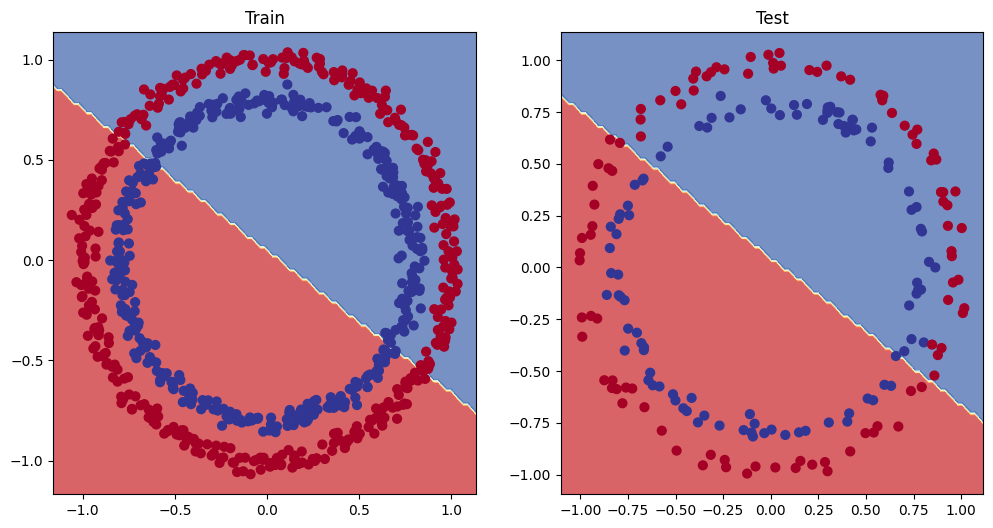

In [89]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")

plot_decision_boundary(model_0, X_test, y_test)


# Improving a model

| Model improvement technique* | What does it do? |
|------------------------------|------------------|
| **Add more layers** | Each layer *potentially* increases the learning capabilities of the model with each layer being able to learn some kind of new pattern in the data. More layers are often referred to as making your neural network **deeper**. |
| **Add more hidden units** | Similar to the above, more hidden units per layer means a *potential* increase in learning capabilities of the model. More hidden units are often referred to as making your neural network **wider**. |
| **Fitting for longer (more epochs)** | Your model might learn more if it had more opportunities to look at the data. |
| **Changing the activation functions** | Some data just can’t be fit with only straight lines (like what we’ve seen), using non-linear activation functions can help with this (hint, hint). |
| **Change the learning rate** | Less model specific, but still related, the learning rate of the optimizer decides how much a model should change its parameters each step, too much and the model overcorrects, too little and it doesn’t learn enough. |
| **Change the loss function** | Again, less model specific but still important, different problems require different loss functions. For example, a binary cross entropy loss function won’t work with a multi-class classification problem. |
| **Use transfer learning** | Take a pretrained model from a problem domain similar to yours and adjust it to your own problem. We cover transfer learning in notebook 06. |


In [90]:
class CircleModelV1(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer_1 = nn.Linear(2, 10)
        self.layer_2 = nn.Linear(10, 10)
        self.layer_3 = nn.Linear(10, 1)
    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [91]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [92]:
torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_1.train()

    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_pred, y_train)
    acc = accuracy_fn(y_train, y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()


    #testing

    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)
    
    if epoch % 100 == 0:
        print(f"epoch: {epoch} | loss: {loss:.5f} | acc: {acc:.2f} | test loss {test_loss:.5f} | test acc: {test_acc:.2f}")


epoch: 0 | loss: 0.75769 | acc: 50.88 | test loss 0.69261 | test acc: 51.00
epoch: 100 | loss: 0.75769 | acc: 50.88 | test loss 0.69261 | test acc: 51.00
epoch: 200 | loss: 0.75769 | acc: 50.88 | test loss 0.69261 | test acc: 51.00
epoch: 300 | loss: 0.75769 | acc: 50.88 | test loss 0.69261 | test acc: 51.00
epoch: 400 | loss: 0.75769 | acc: 50.88 | test loss 0.69261 | test acc: 51.00
epoch: 500 | loss: 0.75769 | acc: 50.88 | test loss 0.69261 | test acc: 51.00
epoch: 600 | loss: 0.75769 | acc: 50.88 | test loss 0.69261 | test acc: 51.00
epoch: 700 | loss: 0.75769 | acc: 50.88 | test loss 0.69261 | test acc: 51.00
epoch: 800 | loss: 0.75769 | acc: 50.88 | test loss 0.69261 | test acc: 51.00
epoch: 900 | loss: 0.75769 | acc: 50.88 | test loss 0.69261 | test acc: 51.00


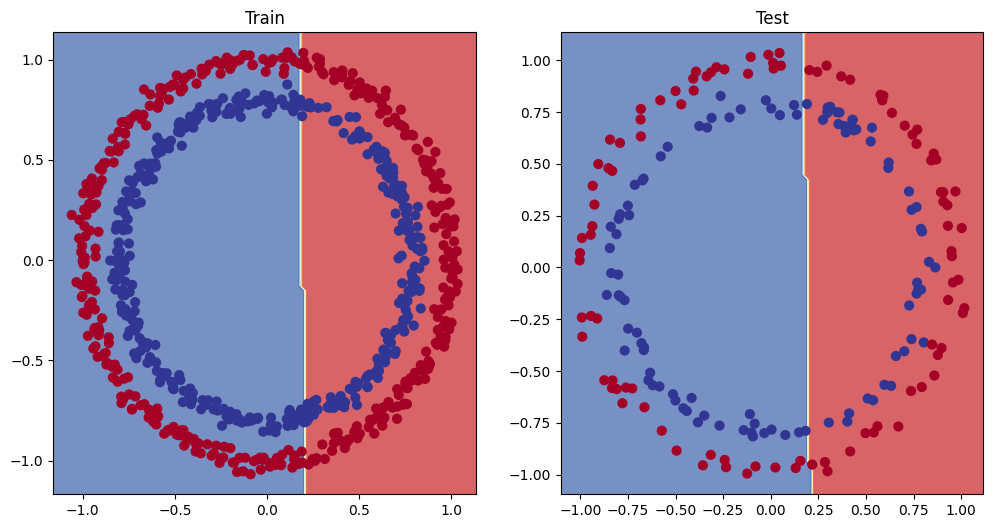

In [93]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

# The missing piece: non-linearity

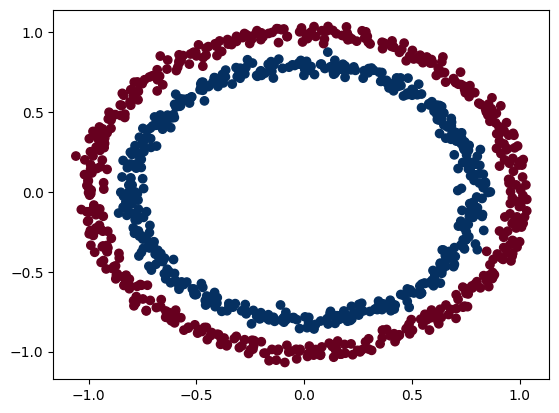

In [94]:
n_samples = 1000

X, y = make_circles(n_samples=1000, noise = 0.03, random_state= 42,)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap= plt.cm.RdBu)
plt.show()

In [95]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

## Building a model with non-linearity

In [96]:
class CircleModelV2(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer_1 = nn.Linear(2, 10)
        self.layer_2 = nn.Linear(10, 10)
        self.layer_3 = nn.Linear(10, 1)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [97]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.05)


In [98]:
torch.manual_seed(42)

epochs = 10000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_3.train()
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)
    
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    #testing
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)
    if (epoch % 100 == 0):
        print(f"epoch: {epoch} | loss: {loss:.5f} | acc: {acc:.2f} | test loss {test_loss:.5f} | test acc: {test_acc:.2f}")


epoch: 0 | loss: 0.69295 | acc: 50.00 | test loss 0.69322 | test acc: 50.00
epoch: 100 | loss: 0.69181 | acc: 58.38 | test loss 0.69178 | test acc: 59.50
epoch: 200 | loss: 0.69115 | acc: 52.88 | test loss 0.69103 | test acc: 52.50
epoch: 300 | loss: 0.69050 | acc: 52.88 | test loss 0.69027 | test acc: 55.00
epoch: 400 | loss: 0.68977 | acc: 53.37 | test loss 0.68940 | test acc: 55.00
epoch: 500 | loss: 0.68894 | acc: 53.50 | test loss 0.68841 | test acc: 56.00
epoch: 600 | loss: 0.68795 | acc: 53.00 | test loss 0.68724 | test acc: 56.00
epoch: 700 | loss: 0.68676 | acc: 52.62 | test loss 0.68588 | test acc: 56.50
epoch: 800 | loss: 0.68516 | acc: 52.75 | test loss 0.68413 | test acc: 56.50
epoch: 900 | loss: 0.68325 | acc: 52.75 | test loss 0.68199 | test acc: 56.00
epoch: 1000 | loss: 0.68101 | acc: 52.75 | test loss 0.67942 | test acc: 56.50
epoch: 1100 | loss: 0.67835 | acc: 53.37 | test loss 0.67642 | test acc: 56.00
epoch: 1200 | loss: 0.67512 | acc: 54.50 | test loss 0.67286 | t

In [99]:
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

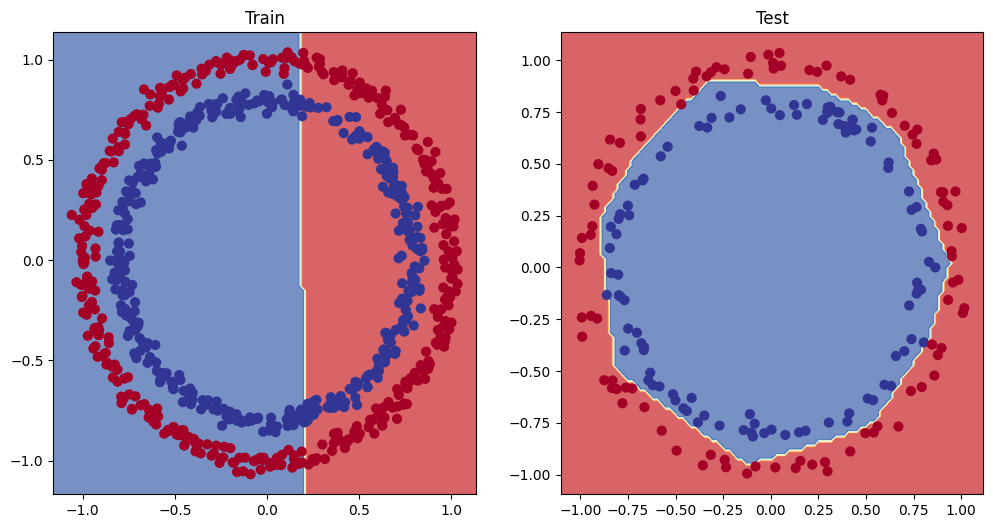

In [100]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

# Replicating non-linear activation functions

In [101]:
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

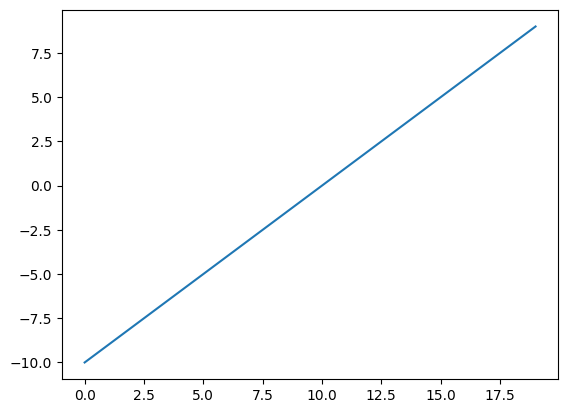

In [102]:
plt.plot(A)
plt.show()

In [103]:
def relu(x):
    return torch.maximum(torch.tensor(0.), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

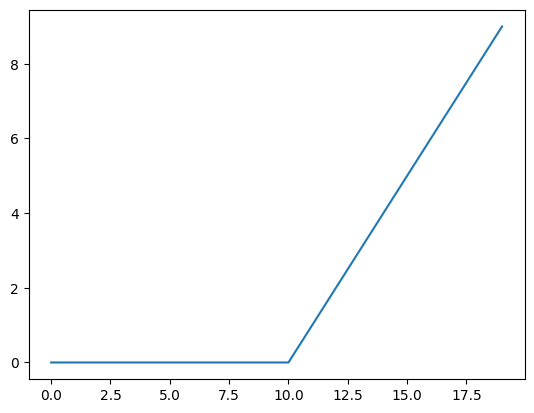

In [104]:
plt.plot(relu(A))
plt.show()

The sigmoid function formula goes like so:

$$ out_i = \frac{1}{1+e^{-input_i}} $$

Or using $x$ as input:

$$ S(x) = \frac{1}{1+e^{-x_i}} $$

Where $S$ stands for sigmoid, $e$ stands for exponential (torch.exp()) and $i$ stands for a particular element in a tensor.

Let's build a function to replicate the sigmoid function with PyTorch.

In [105]:
def sigmoid(x):
    return 1. / (1 + torch.exp(-x))

sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

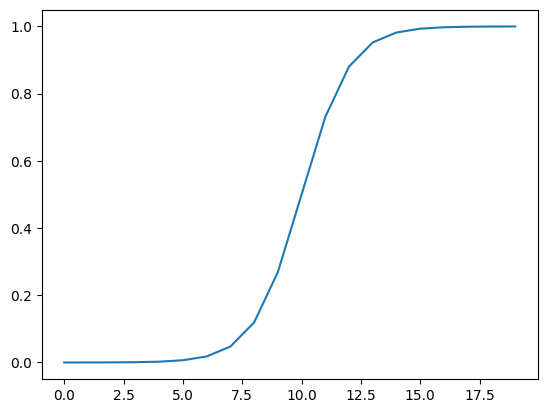

In [106]:
plt.plot(sigmoid(A))
plt.show()

# Putting things together by building a multi-class PyTorch model

## Creating multi-class classification data

In [107]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000, 
                            n_features= NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)



In [108]:
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob[:5], y_blob[:5]

(tensor([[-8.4134,  6.9352],
         [-5.7665, -6.4312],
         [-6.0421, -6.7661],
         [ 3.9508,  0.6984],
         [ 4.2505, -0.2815]]),
 tensor([3, 2, 2, 1, 1]))

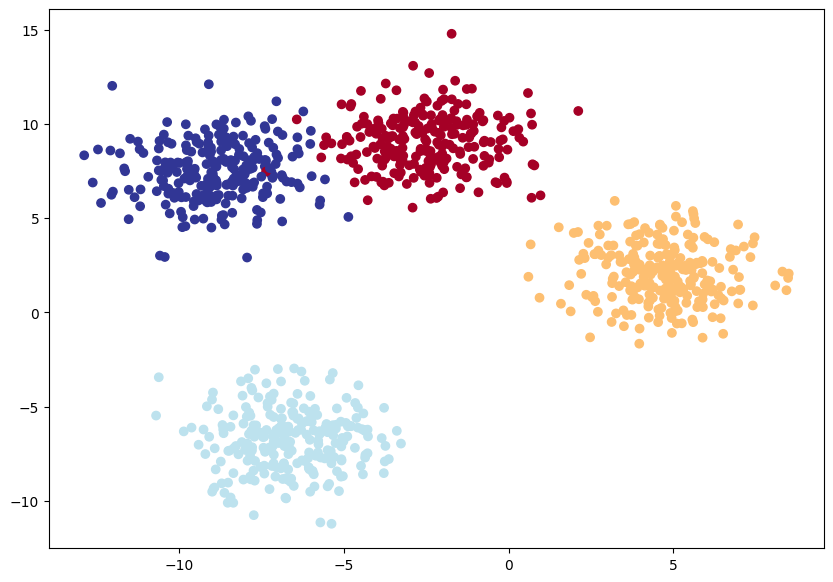

In [109]:
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)
plt.show()

## building a multi-class classification model in PyTorch

In [110]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [111]:
from torch import nn

class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units = 8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(input_features, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_features),
        )
    def forward(self, x):
        return self.linear_layer_stack(x)
        
model_4 = BlobModel(NUM_FEATURES, NUM_CLASSES, 8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [112]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

In [113]:
model_4(X_blob_train.to(device))[:5]

tensor([[-0.7586, -0.6810, -1.5180, -1.1178],
        [-0.2398, -1.2335, -0.9858, -0.2899],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [ 0.2391, -0.2472,  0.1494,  0.0213],
        [-0.1214, -0.9804, -0.6918, -0.1923]], grad_fn=<SliceBackward0>)

In [114]:
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [115]:
y_logits = model_4(X_blob_test.to(device))

y_pred_probs = torch.softmax(y_logits, dim=1)

In [116]:
y_logits[:5], y_pred_probs[:5]

(tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
         [-0.0973, -0.9431, -0.5963, -0.1371],
         [ 0.2528, -0.2379,  0.1882, -0.0066],
         [-0.4134, -0.5204, -0.9303, -0.6963],
         [-0.3118, -1.3736, -1.1991, -0.3834]], grad_fn=<SliceBackward0>),
 tensor([[0.3169, 0.3244, 0.1405, 0.2182],
         [0.3336, 0.1432, 0.2026, 0.3206],
         [0.3011, 0.1843, 0.2823, 0.2323],
         [0.3078, 0.2766, 0.1836, 0.2320],
         [0.3719, 0.1286, 0.1532, 0.3463]], grad_fn=<SliceBackward0>))

In [117]:
torch.sum(y_pred_probs[0])

tensor(1., grad_fn=<SumBackward0>)

In [118]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.3169, 0.3244, 0.1405, 0.2182], grad_fn=<SelectBackward0>)
tensor(1)


In [119]:
torch.manual_seed(42)

epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    #turn on training mode
    model_4.train()
    #forward pass
    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim = 1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_4.eval()

    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_blob_test, test_pred)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.15883, Acc: 40.38% | Test Loss: 1.07554, Test Acc: 48.00%
Epoch: 10 | Loss: 0.64476, Acc: 96.75% | Test Loss: 0.66069, Test Acc: 97.50%
Epoch: 20 | Loss: 0.42535, Acc: 98.50% | Test Loss: 0.43074, Test Acc: 100.00%
Epoch: 30 | Loss: 0.25294, Acc: 99.12% | Test Loss: 0.24508, Test Acc: 99.50%
Epoch: 40 | Loss: 0.11232, Acc: 99.25% | Test Loss: 0.10229, Test Acc: 99.50%
Epoch: 50 | Loss: 0.06627, Acc: 99.25% | Test Loss: 0.05848, Test Acc: 99.50%
Epoch: 60 | Loss: 0.05068, Acc: 99.25% | Test Loss: 0.04293, Test Acc: 99.50%
Epoch: 70 | Loss: 0.04300, Acc: 99.25% | Test Loss: 0.03491, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03836, Acc: 99.25% | Test Loss: 0.02988, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03525, Acc: 99.25% | Test Loss: 0.02663, Test Acc: 99.50%


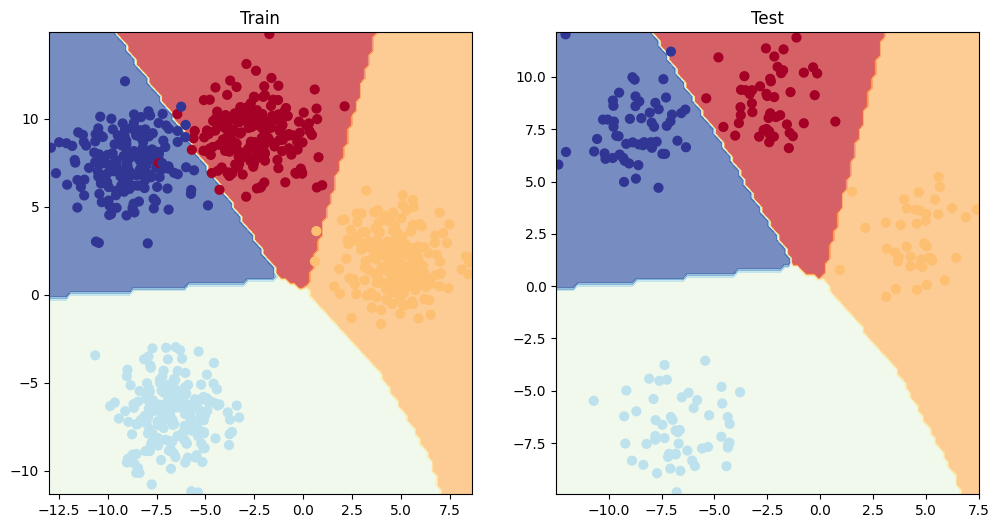

In [120]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

| Metric name/ Evaluation method | Definition | Code |
|--------------------------------|-------------|------|
| **Accuracy** | Out of 100 predictions, how many does your model get correct? E.g. 95% accuracy means it gets 95/100 predictions correct. | `torchmetrics.Accuracy()`<br>or<br>`sklearn.metrics.accuracy_score()` |
| **Precision** | Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0). | `torchmetrics.Precision()`<br>or<br>`sklearn.metrics.precision_score()` |
| **Recall** | Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives. | `torchmetrics.Recall()`<br>or<br>`sklearn.metrics.recall_score()` |
| **F1-score** | Combines precision and recall into one metric. 1 is best, 0 is worst. | `torchmetrics.F1Score()`<br>or<br>`sklearn.metrics.f1_score()` |
| **Confusion matrix** | Compares the predicted values with the true values in a tabular way, if 100% correct, all values in the matrix will be top left to bottom right (diagonal line). | `torchmetrics.ConfusionMatrix`<br>or<br>`sklearn.metrics.plot_confusion_matrix()` |
| **Classification report** | Collection of some of the main classification metrics such as precision, recall and f1-score. | `sklearn.metrics.classification_report()` |
